# Environment set-up

In [1]:
%%capture
!pip install gensim==3.8.3
!pip install pyLDAvis==3.2.2
!pip install numpy==1.17.4
!pip install pyLDAvis==2.1.2
!pip install -U transformers
!pip install chart-studio
!pip install plotly==4.14.3
!pip install python-bidi

In [20]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Topic_Modeling'
!mkdir Graphs_photo
!mkdir TopKeyWordsOfTopics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Topic_Modeling
mkdir: cannot create directory ‘Graphs_photo’: File exists


In [3]:
%%capture
## general python packages

import re
import numpy as np
import pandas as pd
from pprint import pprint
import warnings
## NLP packages
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
## visualization packages
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import plotly.express as px
import chart_studio.plotly as py
import chart_studio.grid_objs as go
from plotly.offline import iplot, init_notebook_mode
from bidi.algorithm import get_display
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# environment setup and download some models and NLP pacckages stuff to use later
warnings.filterwarnings("ignore",category=DeprecationWarning)
nlp = spacy.load("en_core_web_sm")
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nltk.download('punkt')
nltk.download('stopwords')
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')

In [4]:
## download the mallet  to use for topic-modeling
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2023-08-21 19:35:40--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-08-21 19:35:40--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  34.5MB/s    in 0.4s    

2023-08-21 19:35:40 (34.5 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

# Loading Data and get a brief overview of columns

In [5]:
df = pd.read_json("train_reviews.json")
print(f"Data head: \n {df.head()}\n")
print(f"Shape of my data: {df.shape}\n")
print(f"Information about my data: {df.info()}\n")
df['num_stars']=df['stars'].apply(lambda x: re.sub('\D','', x))
df['num_stars']=df['num_stars'].astype(int)
print(f"The number of null values for my data: \n{df.isnull().sum()}\n")
print(f"Number of duplicate reviews in `text` column of data: {df.shape[0] - df.drop_duplicates(subset=['text']).shape[0]}\n")
print("By hovering through data, this duplicates are the rows that gathered from different sources(url) or just a short review that happens to be the same\nDroping these duplicate since it affect our topic modeling algorithm\n")
df.drop_duplicates(subset=["text"], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"shape of data after dropping duplicate rows: {df.shape}\n")
print(f"colum's type of data : \n{df.dtypes}\n")

Data head: 
                        date  \
0 2015-10-10 14:32:51+00:00   
1 2015-09-22 17:04:56+00:00   
2 2015-03-13 23:37:05+00:00   
3 2015-01-13 12:26:52+00:00   
4 2011-05-28 15:00:36+00:00   

                                               title  \
0  Bad customer service. Staff are very impolite ...   
1                               Pretty awful service   
2                                        Awful staff   
3                                          Very good   
4                                      Check it out.   

                                                text  \
0  Used national rail twice and on both occasions...   
1  I phoned National rail to find out why several...   
2  I travel from Brokenhast to southampton centra...   
3  Saved about £50 on a single trip using Nationa...   
4  I always use the national rail enquiry site wh...   

                                                 url  \
0  https://uk.trustpilot.com/review/www.nationalr...   
1  https://uk.

In [6]:
## geting Year, Month and day_of_week for further use
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].apply(lambda x: x.strftime('%B'))
df['day_of_week'] = df['date'].dt.day_name()

# Preprocessing and EDA

**Class for text preprocessing**

In [7]:
class TextPreprocessing():
    """Class for preprocessing text data."""

    def __init__(self):
        self.punctuation = list(string.punctuation)
        self.stop_words = stopwords.words('english') + self.punctuation + ['\\n'] + ['quot']

    def remove_Emails(self, data):
        # Remove Emails
        return [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    def remove_new_line(self, data):
        # Remove new line characters
        self.data = [re.sub('\s+', ' ', sent) for sent in data]

    def remove_distracting_single_quotes(self, data):
        # Remove distracting single quotes
        self.data = [re.sub("\'", "", sent) for sent in data]

    def sent_to_words(self, sentences):
      for sentence in sentences:
          yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(self, texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    def lemmatization(self, texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent))
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out


In [8]:
df = df[df["text"].apply(lambda x: len(x)>40)]
print("preporcessing text column including stopword removal, lemmatization, filter tokens based on their POS tags ...")
df.reset_index(drop=True, inplace=True)
data = df.text.values.tolist()

preporcessing text column including stopword removal, lemmatization, filter tokens based on their POS tags ...


In [9]:
#Calling class and class methods
TPre = TextPreprocessing()
data = df.text.values.tolist()
#sentences to word
data_words = list(TPre.sent_to_words(data))

In [10]:
# Remove Stop Words
data_words_nostops = TPre.remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = TPre.lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

df['tokens'] =data_lemmatized

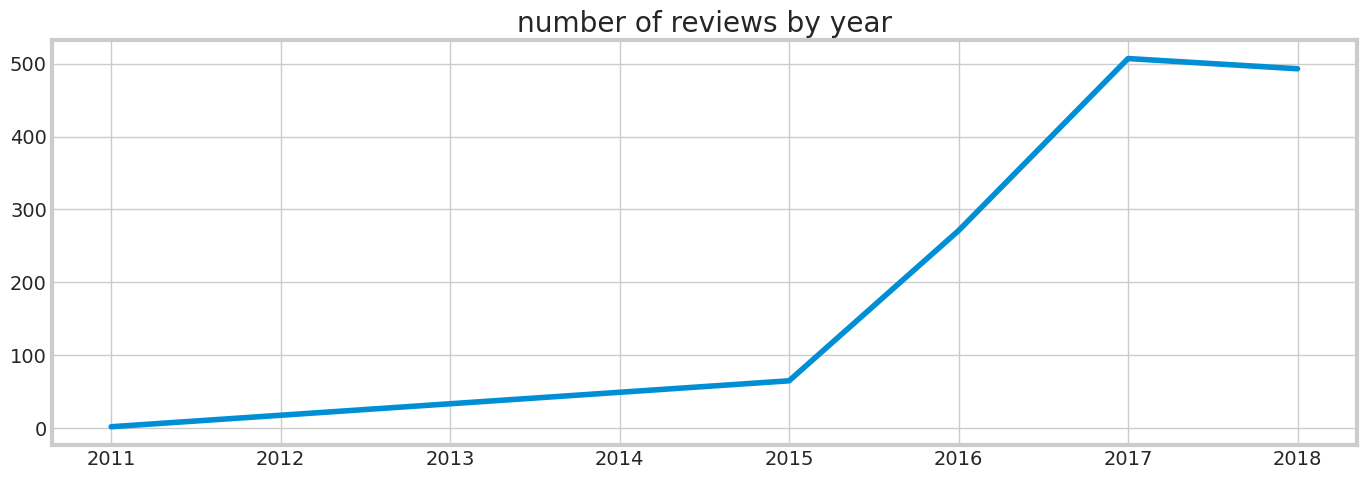

In [11]:
#number of reviews by year
C_year= df.Year.value_counts().sort_index()
C_year.plot(kind='line'  ,  x='year',figsize=(15,5),
    y='text',
    title='number of reviews by year')
plt.savefig("Graphs_photo/number_of_review_by_year.png")

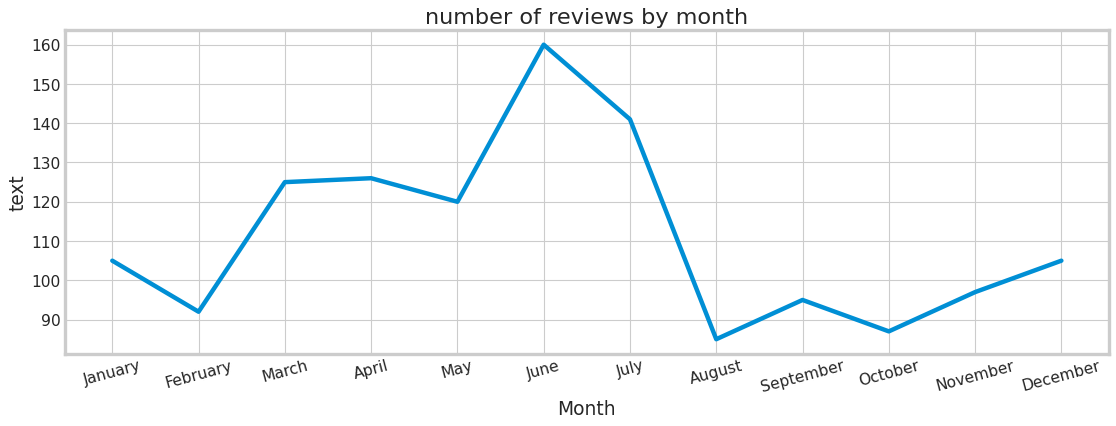

In [12]:
#number of reviews by month
month_grouped_df = df.groupby(["Month"]).count().reset_index()
sort_order=['January','February','March','April','May','June','July','August','September','October','November','December']
month_grouped_df["Month"] = pd.Categorical(month_grouped_df["Month"], categories=sort_order, ordered=True)
plt.figure(figsize=(15,5), dpi=80)
sns.lineplot(x="Month", y="text", data=month_grouped_df)
plt.xticks(rotation=15)
plt.title('number of reviews by month')
plt.savefig("Graphs_photo/number_of_review_by_month.png")
plt.show();

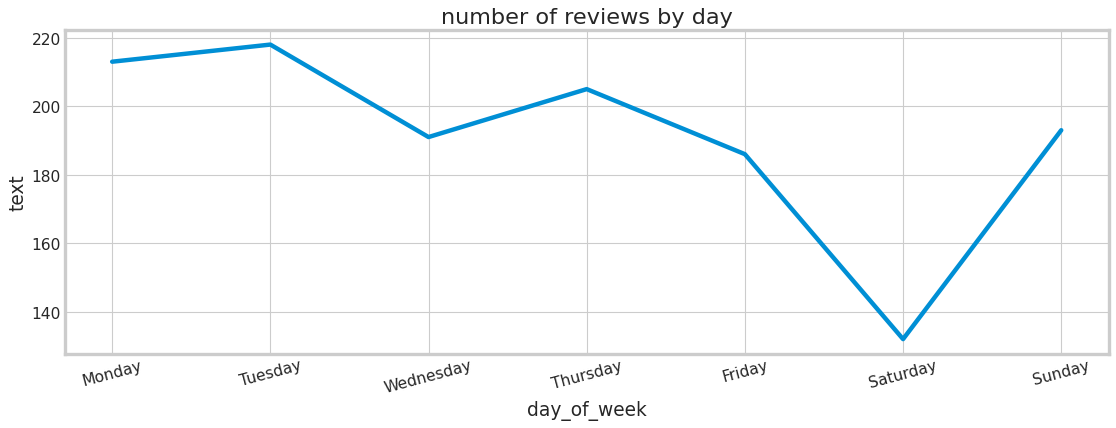

In [13]:
#number of reviews by day
month_grouped_df = df.groupby(["day_of_week"]).count().reset_index()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
month_grouped_df["day_of_week"] = pd.Categorical(month_grouped_df["day_of_week"], categories=days, ordered=True)
plt.figure(figsize=(15,5), dpi=80)
sns.lineplot(x="day_of_week", y="text", data=month_grouped_df)
plt.xticks(rotation=15)
plt.title('number of reviews by day')
plt.savefig("Graphs_photo/number_of_review_by_day.png")

plt.show();

# Topic Moodeing Using LDA algorithm

**Create the Dictionary and Corpus needed for Topic Modeling**

In [14]:
#convert a list of words into sentences
df['lemmatized']= [' '.join(i) for i in data_lemmatized]
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

**Building the Topic Model**

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**View the topics in LDA model with wordcloud**

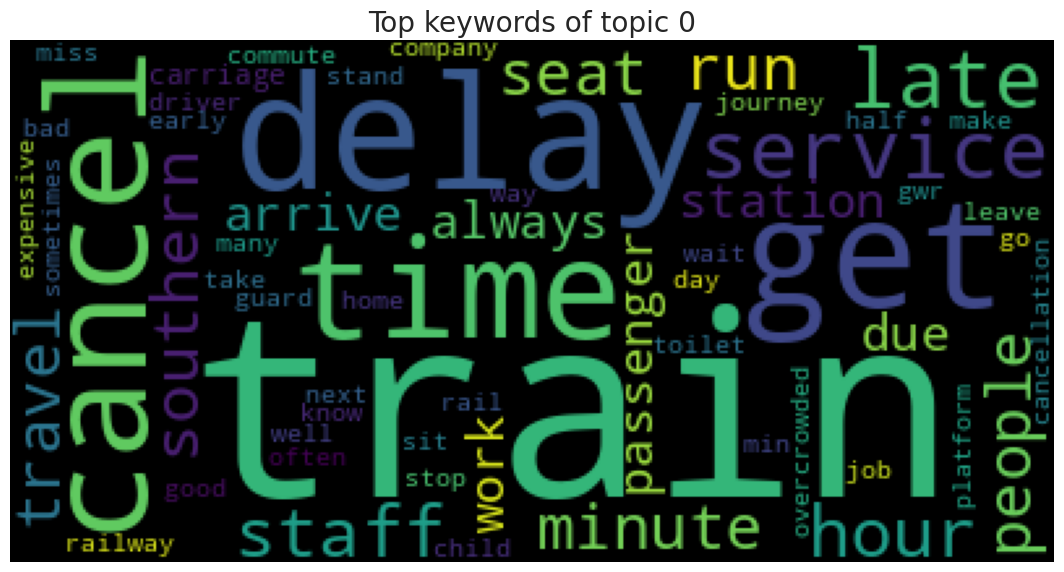

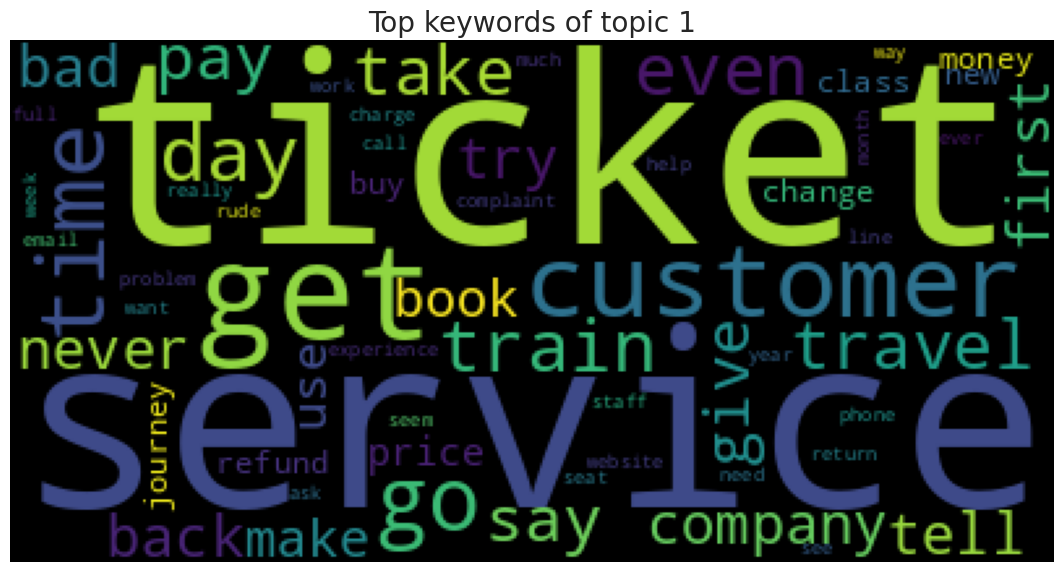

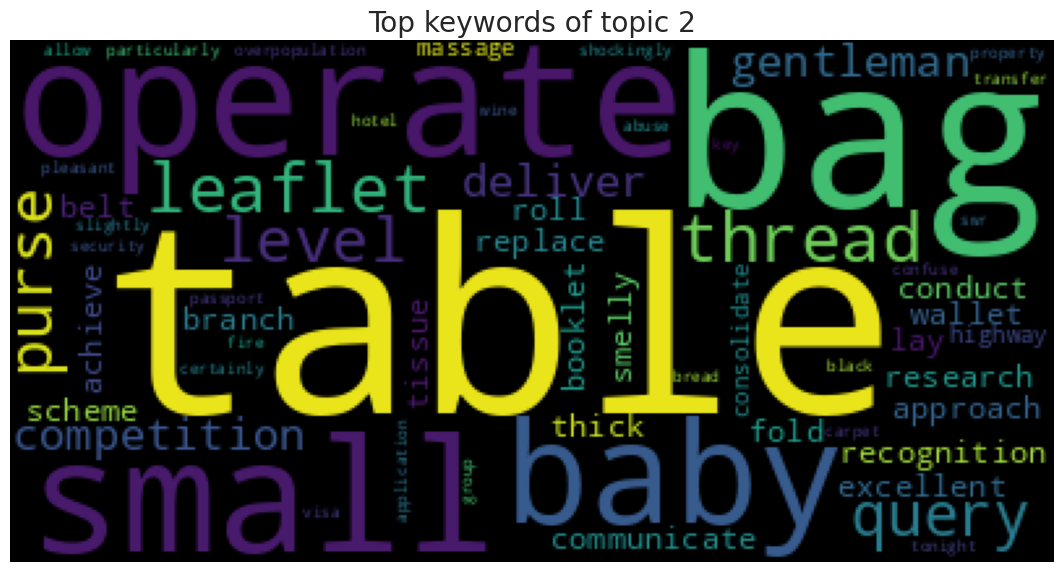

In [21]:
def show_wordcloud(data):
    wordcloud=WordCloud().fit_words(dict(lda_model.show_topic(t, 60)))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.title("Top keywords of topic " + str(t))
    plt.imshow(wordcloud)
    plt.savefig(f"TopKeyWordsOfTopics/Top keywords of topic {t}.png")
    plt.show()

for t in range(lda_model.num_topics):
    show_wordcloud(corpus)


**Compute Model Perplexity and Coherence Score**

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,
texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.072800406255035

Coherence Score:  0.5001183851947035


**Visualize the topics-keywords**

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



**Building LDA Mallet Model**

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

**How to find the optimal number of topics for LDA?**

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

**Finding the dominant topic in each sentence**

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

**Find the most representative document for each topic**

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

**Topic distribution across documents**

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

**Saving csvs**

In [ ]:
df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']].to_csv("df_dominant_topic.csv", index=False)
sent_topics_sorteddf_mallet[['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]].to_csv("sent_topics_sorted.csv", index=False)
